In [106]:
## WLC model 

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

kT = 4.11 #pN 
lp = 0.5 #nm
lc = 45 #nm corrisponde a un dLc perchè Lc in folded state non è zero


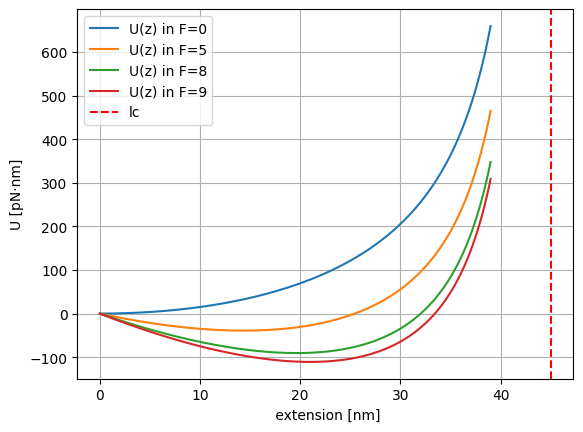

In [187]:
import numpy as np

def F_wlc(dz):
    Fwlc = (kT / lp) * (1 / 4 * (1 - dz / lc)**(-2) + dz / lc - 1/4)
    return Fwlc

# Potential energy of unfolded state with WLC force model.
def U_wlc(z, F): 
    U = (kT / lp) * (-0.25 * (lc**2) / (z - lc) + z**2 / (2 * lc) - 0.25 * z) - F * z
    return U


z = np.linspace(0, 39, 500)  # from 1 to 29 nm
Fwlc  = F_wlc(z)
F_list = [0, 5, 8, 9]
for F in F_list:

    #plt.plot(z, Fwlc, label="F(z)")
    plt.plot(z, U_wlc(z, F) - U_wlc(z,F)[0], label=f"U(z) in F={F}")  # normalizzo 
    plt.xlabel(" extension [nm]")
    plt.ylabel("U [pN·nm]")
    plt.legend()
    plt.grid(True)
plt.axvline(lc, linestyle = "--", color= "red", label= "lc")
plt.legend()
plt.show()


In [108]:
# actual potential backgroud 
import pandas as pd
from scipy.optimize import minimize_scalar
from scipy.integrate import quad

# s = barrier width 
# x_dag = posizione del massimo
# U0 = profondità folded
# G0 = altezza della barriera 
# a = ripidità folded 

x_dag, D = 11, 3000 #nm2/s
a, G0, U0, s =  0.22, 7, 92, 12
z = np.linspace(-4, 30, 500)  # from 1 to 29 nm

def U_fold(z):
    return U0 * (1 - np.exp(- a * z))**2  + G0 * np.exp(-((z - x_dag)**2) / s)

offset = U_wlc(z, F)[0]  
def U_total(z):
    return U_wlc(z, F) - offset + U_fold(z)

def mfpt(x, x_a, x_b, U, kT, D):    
        def inner_integral(y):
            result, _ = quad(lambda z: np.exp(-U(z) / kT), x_a, y)
            return result
        
        def outer_integral():
            result, _ = quad(lambda y: np.exp(U(y) / kT) * inner_integral(y), x, x_b)
            return result

        return outer_integral() / D



# fading 
   # fade = (1 / (1 + np.exp( -2* (z - x_dag))) ) 
   # U_total =  fade * U_wlc (z, F) + (1- fade)* U_fold(z)

    # minimi 
    # mask = z> x_dag 
    # U_min = U_total[mask].min() 
    # mask = z < x_dag            
    # U_min_f = U_total[mask].min() 

    # # plt.plot(z, U_wlc(z, F) - U_wlc(z,F)[0], label=f"U_unf F={F}", linestyle =":")
    # # plt.plot(z, U_fold(z), label= f" U_fold F = {F}", linestyle =":")

wlc = []
# MFPS 
for F in (7, 7.5, 8, 8.5, 9):
    x_folded = minimize_scalar(U_total, bounds=(-1, 5), method='bounded').x
    x_unfolded =minimize_scalar(U_total, bounds=(15, 25), method='bounded').x
    x_top = minimize_scalar(lambda x: -U_total(x), bounds=(9.5, 10.5), method='bounded').x

    dG_fold = U_total(x_top) - U_total(x_unfolded)
    dG_unfold = U_total(x_top) - U_total(x_folded) 

    mfpt_value = mfpt(x_folded, x_folded - 5 , x_unfolded, U_total, kT, D)
    rate_unfold = 1 / mfpt_value
    mfpt_value2 = mfpt(x_unfolded, x_unfolded + 5, x_folded, U_total, kT, D)
    rate_fold = 1 / mfpt_value2

    wlc.append([F, dG_fold, dG_unfold, x_folded, x_unfolded, x_top, rate_unfold, rate_fold ])


df_wlc = pd.DataFrame(wlc, columns=["F", "dG_fold", "dG_unfold", "x_f", "x_u", "x_top", "mfpt_r_u", "mfpt_r_f"])
df_wlc


,F,dG_fold,dG_unfold,x_f,x_u,x_top,mfpt_r_u,mfpt_r_f
0,7.0,8.001140,27.917255,1.067815,17.079701,10.499994,0.245896,13.114935
1,7.5,11.491999,23.230587,1.187337,17.896300,10.499994,0.742691,5.748956
2,8.0,15.478608,18.679147,1.319214,18.763413,10.175063,2.038039,2.140891
3,8.5,20.084068,14.383485,1.466856,19.617065,9.783136,4.985743,0.672117
4,9.0,25.298258,10.361751,1.635466,20.413846,9.500006,10.716543,0.177379


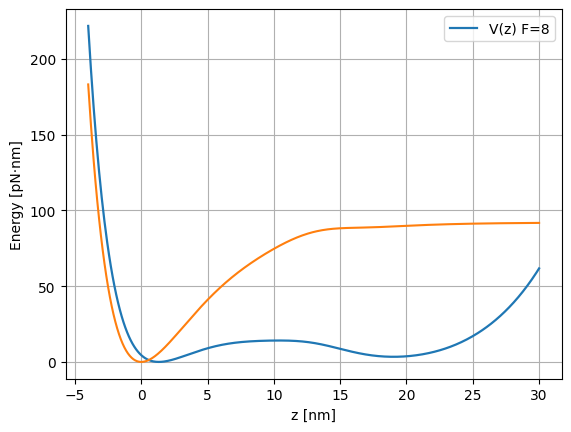

In [121]:
F = 8
plt.plot(z, U_total(z) - U_total(z).min(), label=f"V(z) F={F}", linewidth=1.6)
plt.plot(z, U_fold(z))
plt.xlabel("z [nm]")
plt.ylabel("Energy [pN·nm]")
plt.grid()
plt.legend()
    #plt.ylim(-100, 50)
    # plt.xlim(-6, 40)
    # plt.axhline(U_min, color='red', linestyle='--', linewidth= 0.6)
    # plt.axhline(U_min_f, color='red', linestyle='--', linewidth=0.6)
plt.show()


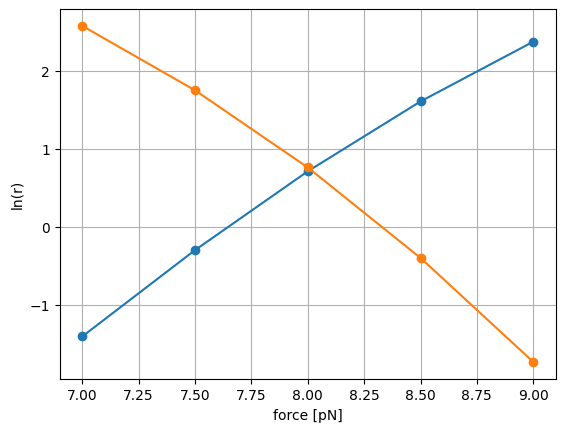

In [122]:
plt.plot(df_wlc["F"], np.log(df_wlc["mfpt_r_u"]), label = "Unfolding r", marker="o")
plt.plot(df_wlc["F"], np.log(df_wlc["mfpt_r_f"]), label="Folding r", marker="o")
plt.ylabel("ln(r)")
plt.xlabel("force [pN]")
plt.grid(True)
plt.show()

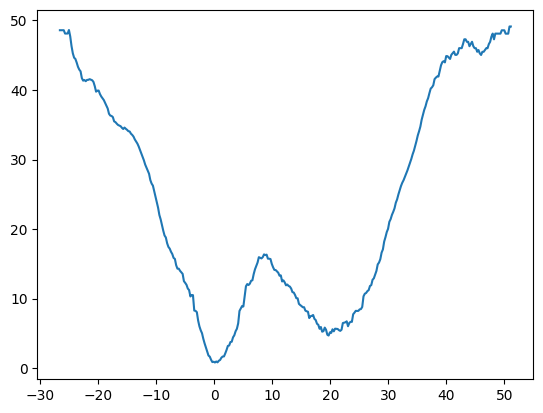

In [ ]:
# upload file 
df = pd.read_csv("Free_energy.txt", header=None, names=["U"])
x_values = -26.6 + 0.22 * np.arange(350)
df["x"] = x_values

plt.plot(x, df["U"])
plt.show()

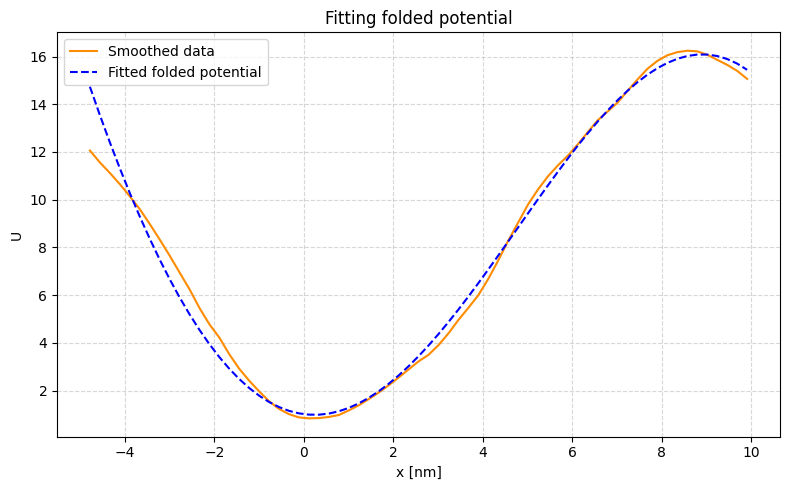

In [ ]:
# FITTING
from scipy.optimize import curve_fit

def U_fold_fit(z, a, G0, U0, s, x_dag):
    return U0 * (1 - np.exp(-a * z))**2 + G0 * np.exp(-((z - x_dag)**2) / s)
def U_total_fit(z, a, G0, U0, s, x_dag):
    offset = U_wlc(z, F)[0]  # F deve essere definito globalmente o passato
    return U_wlc(z, F) - offset + U_fold_fit(z, a, G0, U0, s, x_dag)

p0 = [0.22, 4, 40, 12, 13]  
#p0 = [  0.27923514,  41.85972301,  63.57124674, 199.25610384, 17.590832]

x = np.array(x)
y_smooth = np.array(y_smooth)
F = 8

mask = (x > -5) & (x < 10)
x_fit = x[mask]
y_fit = y_smooth[mask]

popt, pcov = curve_fit(U_total_fit, x_fit, y_fit, p0=p0, maxfev=10000)
a_fit, G0_fit, U0_fit, s_fit, x_dag_fit = popt
y_finalfit = U_total_fit(x_fit, *popt)

plt.figure(figsize=(8, 5))
plt.plot(x_fit, y_fit, label="Smoothed data", color="darkorange")
plt.plot(x_fit, y_finalfit, label="Fitted folded potential", color="blue", linestyle="--")
plt.xlabel("x [nm]")
plt.ylabel("U")
plt.title("Fitting folded potential")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


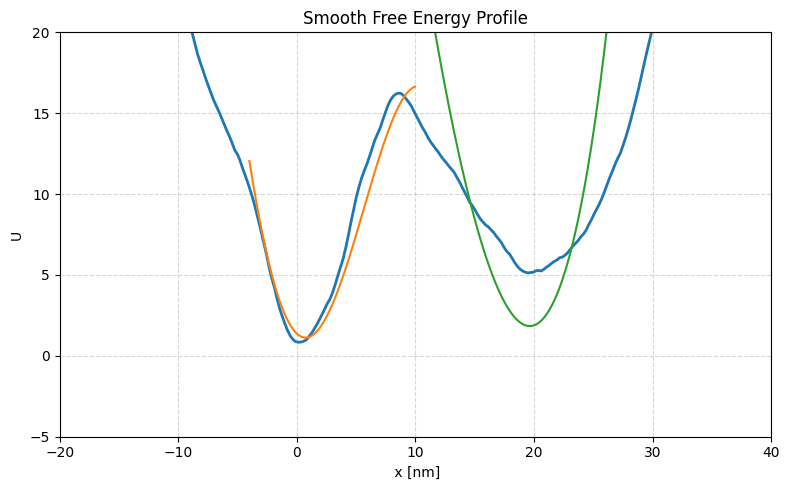

In [216]:
from scipy.signal import savgol_filter

z = np.linspace(-4, 30, 500) 
F = 8
x_dag= 13
a, G0, U0, s =  0.22, 4, 92, 12

#------------------------------------
x = df["x"] - 26.6
y = df["U"]

y_smooth = savgol_filter(y, window_length=15, polyorder=3)
z_fit = z[(z > -5) & (z < 10)]
z_fit_2 = z[z>10]

plt.figure(figsize=(8, 5))
plt.plot(x, y_smooth, linewidth=2)
plt.plot(z_fit, U_total_fit(z_fit, *popt)-8)
plt.plot(z_fit_2, U_wlc(z_fit_2, F))

plt.xlabel(" x [nm]")
plt.ylabel("U")
plt.title("Smooth Free Energy Profile")
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(-5, 20)
plt.xlim(-20, 40)
plt.tight_layout()

plt.show()


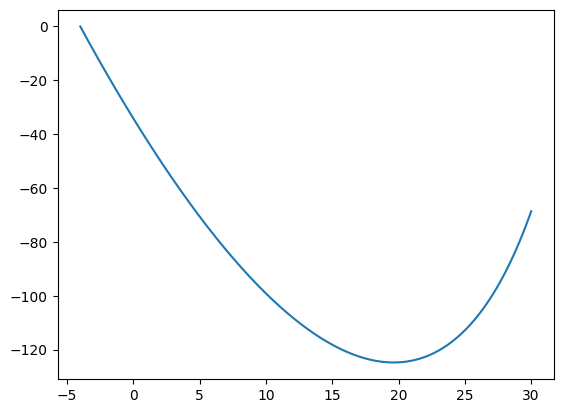

In [ ]:
plt.plot(z, U_wlc(z, F) - U_wlc(z,F)[0], label=f"U(z) in F={F}")  # normalizzo 
